In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

# Download stopwords
import nltk
nltk.download('stopwords')

# Load dataset
df = pd.read_csv('spam_assassin.csv')

# Remove email headers and metadata (optional)
df['text'] = df['text'].apply(lambda x: re.sub(r'From:.*\n', '', x))

# Convert text to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

# Remove special characters and numbers
df['text'] = df['text'].apply(lambda x: re.sub(r'\W', ' ', x))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Stemming
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Ensure stopwords resource is available
nltk.download('stopwords')

# Load dataset
df = pd.read_csv('spam_assassin.csv')


# Step 1: Identify missing values
print(df.isnull().sum())  # Check for missing values in the dataset

# Step 2: Handle missing values (if any)
# Option 1: Remove rows with missing text data
df.dropna(subset=['text'], inplace=True)

# Option 2: Impute missing values (if any)
df['text'].fillna('unknown', inplace=True)

# Step 3: Further noise removal (if needed)
# Remove text segments that are too short (e.g., less than 5 characters) or too long
df = df[df['text'].str.len() > 5]  # Example of filtering very short text

# Step 1: Remove email headers and metadata (optional)
# Assuming headers are separated by '\n'
df['text'] = df['text'].apply(lambda x: re.sub(r'From:.*\n', '', x))

# Step 2: Convert text to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

# Step 3: Remove special characters and numbers
df['text'] = df['text'].apply(lambda x: re.sub(r'\W', ' ', x))

# Step 4: Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Step 5: Stemming (reducing words to their root form)
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Optional: View the first few rows of the processed data
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


text      0
target    0
dtype: int64
                                                text  target
0  ilug admin linux ie mon jul 29 11 28 02 2002 r...       0
1  gort44 excit com mon jun 24 17 54 21 2002 retu...       1
2  fork admin xent com mon jul 29 11 39 57 2002 r...       1
3  dcm123 btamail net cn mon jun 24 17 49 23 2002...       1
4  ilug admin linux ie mon aug 19 11 02 47 2002 r...       0


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5796)  # You can adjust the max_features as needed

# Fit and transform the text data to TF-IDF features
X = tfidf_vectorizer.fit_transform(df['text'])

# Convert to a DataFrame for easier handling
X_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
y = df['target']

print(X_df.shape)  # Check the shape of the feature set


(5796, 5796)


In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize a Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=5796)  # You can adjust the number of features

# Fit RFE on the data
rfe = rfe.fit(X_df, y)

# Get the selected features
selected_features = X_df.columns[rfe.support_]
print("Selected Features: ", selected_features)

# Transform the dataset to only include selected features
X_selected = X_df[selected_features]


Selected Features:  Index(['00', '000', '0000', '000000', '000033', '000066', '000080', '000099',
       '0000a0', '0000cc',
       ...
       'zip', 'zone', 'zoo', 'zope', 'zurich', 'zzn', 'zzzlist', 'zzzz',
       'zzzzason', 'zzzzteana'],
      dtype='object', length=5796)


In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (4057, 5796)
Testing set size: (1739, 5796)


In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Make predictions on the test set
nb_predictions = nb_model.predict(X_test)

# Evaluate the accuracy
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))


Naive Bayes Accuracy: 0.9815986198964922
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1172
           1       0.99      0.95      0.97       567

    accuracy                           0.98      1739
   macro avg       0.98      0.97      0.98      1739
weighted avg       0.98      0.98      0.98      1739



In [19]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes classifier
mnb_model = MultinomialNB()

# Train the model
mnb_model.fit(X_train, y_train)

# Make predictions on the test set
mnb_predictions = mnb_model.predict(X_test)

# Evaluate the accuracy
mnb_accuracy = accuracy_score(y_test, mnb_predictions)
print("Multinomial Naive Bayes Accuracy:", mnb_accuracy)
print("Multinomial Naive Bayes Classification Report:\n", classification_report(y_test, mnb_predictions))



Multinomial Naive Bayes Accuracy: 0.9815986198964922
Multinomial Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1172
           1       1.00      0.94      0.97       567

    accuracy                           0.98      1739
   macro avg       0.99      0.97      0.98      1739
weighted avg       0.98      0.98      0.98      1739



In [20]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
j48_model = DecisionTreeClassifier(random_state=42)

# Train the model
j48_model.fit(X_train, y_train)

# Make predictions on the test set
j48_predictions = j48_model.predict(X_test)

# Evaluate the accuracy
j48_accuracy = accuracy_score(y_test, j48_predictions)
print("J48 Decision Tree Accuracy:", j48_accuracy)
print("J48 Decision Tree Classification Report:\n", classification_report(y_test, j48_predictions))


J48 Decision Tree Accuracy: 0.9781483611270846
J48 Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1172
           1       0.97      0.97      0.97       567

    accuracy                           0.98      1739
   macro avg       0.98      0.98      0.98      1739
weighted avg       0.98      0.98      0.98      1739



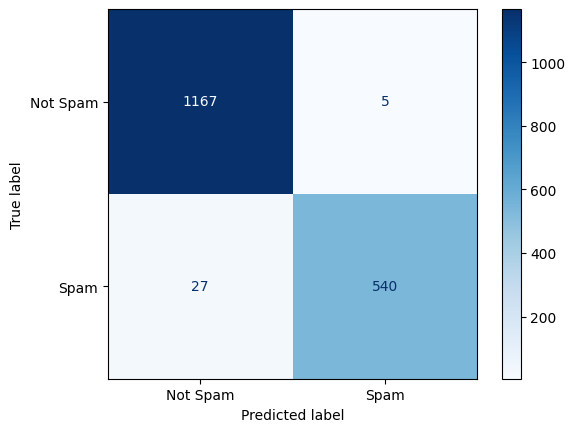

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_predictions)

# Display the confusion matrix
ConfusionMatrixDisplay(nb_conf_matrix, display_labels=["Not Spam", "Spam"]).plot(cmap='Blues')


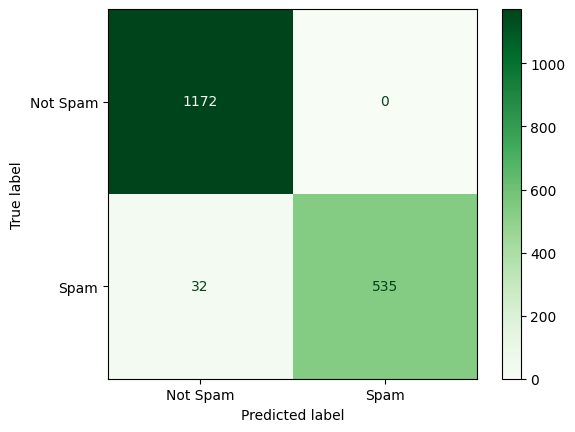

In [23]:
# Calculate confusion matrix for Multinomial Naive Bayes
mnb_conf_matrix = confusion_matrix(y_test, mnb_predictions)

# Display the confusion matrix
ConfusionMatrixDisplay(mnb_conf_matrix, display_labels=["Not Spam", "Spam"]).plot(cmap='Greens')


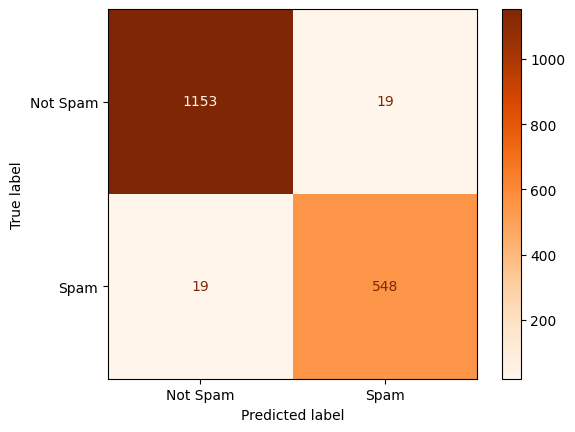

In [24]:
# Calculate confusion matrix for J48 Decision Tree
j48_conf_matrix = confusion_matrix(y_test, j48_predictions)

# Display the confusion matrix
ConfusionMatrixDisplay(j48_conf_matrix, display_labels=["Not Spam", "Spam"]).plot(cmap='Oranges')


In [21]:
print("Summary of Model Accuracies:")
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Multinomial Naive Bayes Accuracy: {mnb_accuracy}")
print(f"J48 Decision Tree Accuracy: {j48_accuracy}")


Summary of Model Accuracies:
Naive Bayes Accuracy: 0.9815986198964922
Multinomial Naive Bayes Accuracy: 0.9815986198964922
J48 Decision Tree Accuracy: 0.9781483611270846
